In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['vgg_face.csv', 'vgg_faceF07.csv', 'vgg_faceF06.csv', 'vgg_faceF04.csv', 'vgg_faceF05.csv', 'vgg_faceF01.csv', 'vgg_faceF00.csv', 'se_16', 'vgg_facebase_line_de.csv', 'vgg_faceF02.csv', 'vgg_faceF03.csv', 'info.txt', 'vgg_face (1).csv', 'vgg_face (3).csv', 'vgg_face (2).csv', 'resnet_bs8', 'pixel_stats.csv', 'vgg_faceF08.csv', 'vgg_faceF09.csv', 'sub_detect_kinship.csv']


In [8]:
sub1 = pd.read_csv('./input/vgg_face.csv')
sub2 = pd.read_csv('./input/vgg_face (1).csv')
sub3 = pd.read_csv('./input/vgg_face (2).csv')
sub4 = pd.read_csv('./input/vgg_face (3).csv')
sub5 = pd.read_csv('./input/sub_detect_kinship.csv')
sub6 = pd.read_csv('./input/vgg_facebase_line_de.csv')
sub7 = pd.read_csv('vgg_facedp0_1.csv')
sub8 = pd.read_csv('submission4.csv')
temp = pd.read_csv('./input/vgg_face (1).csv')


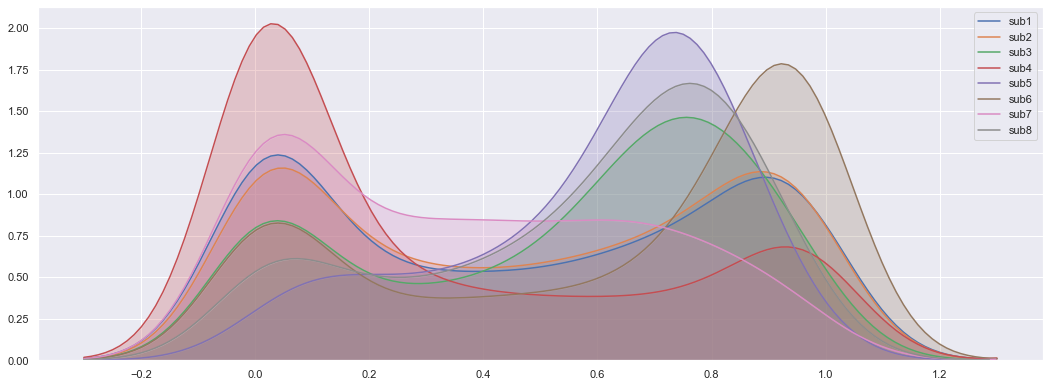

In [9]:
sns.set(rc={'figure.figsize':(18,6.5)})
sns.kdeplot(sub1['is_related'], label="sub1",shade=True,bw=.1)
sns.kdeplot(sub2['is_related'], label="sub2",shade=True,bw=.1)
sns.kdeplot(sub3['is_related'], label="sub3",shade=True,bw=.1)
sns.kdeplot(sub4['is_related'], label="sub4",shade=True,bw=.1)
sns.kdeplot(sub5['is_related'], label="sub5",shade=True,bw=.1)
sns.kdeplot(sub6['is_related'], label="sub6",shade=True,bw=.1)
sns.kdeplot(sub7['is_related'], label="sub7",shade=True,bw=.1)
sns.kdeplot(sub8['is_related'], label="sub8",shade=True,bw=.1)

In [11]:
temp['is_related'] = 0.25*sub1['is_related'] + 0.25*sub6['is_related']+0.25*sub4['is_related']+0.25*sub7['is_related'] 
temp.to_csv('submissio3.csv', index=False )

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

['vgg_face.csv', 'vgg_faceF07.csv', 'vgg_faceF06.csv', 'vgg_faceF04.csv', 'vgg_faceF05.csv', 'vgg_faceF01.csv', 'vgg_faceF00.csv', 'vgg_facebase_line_de.csv', 'vgg_faceF02.csv', 'vgg_faceF03.csv', 'info.txt', 'vgg_face (1).csv', 'vgg_face (3).csv', 'vgg_face (2).csv', 'resnet_bs8', 'pixel_stats.csv', 'vgg_faceF08.csv', 'vgg_faceF09.csv', 'sub_detect_kinship.csv']


In [18]:

sub1 = pd.read_csv('./input/resnet_bs8/vgg_faceF00.csv')
sub2 = pd.read_csv('./input/resnet_bs8/vgg_faceF01.csv')
sub3 = pd.read_csv('./input/resnet_bs8/vgg_faceF02.csv')
sub4 = pd.read_csv('./input/resnet_bs8/vgg_faceF03.csv')
sub5 = pd.read_csv('./input/resnet_bs8/vgg_faceF04.csv')
sub6 = pd.read_csv('./input/resnet_bs8/vgg_faceF05.csv')
sub7 = pd.read_csv('./input/resnet_bs8/vgg_faceF06.csv')
sub8 = pd.read_csv('./input/resnet_bs8/vgg_faceF07.csv')
sub9 = pd.read_csv('./input/resnet_bs8/vgg_faceF08.csv')
sub10 = pd.read_csv('./input/resnet_bs8/vgg_faceF09.csv')


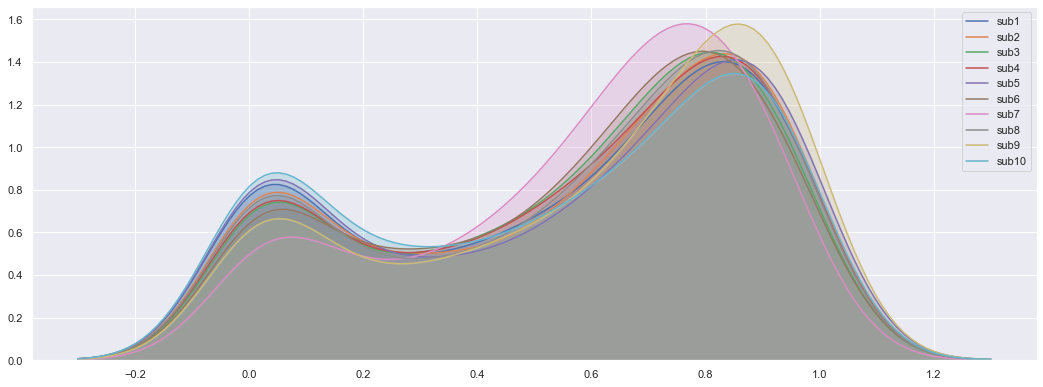

In [21]:
sns.set(rc={'figure.figsize':(18,6.5)})
sns.kdeplot(sub1['is_related'],label="sub1",shade=True,bw=.1)
sns.kdeplot(sub2['is_related'], label="sub2",shade=True,bw=.1)
sns.kdeplot(sub3['is_related'], label="sub3",shade=True,bw=.1)
sns.kdeplot(sub4['is_related'], label="sub4",shade=True,bw=.1)
sns.kdeplot(sub5['is_related'], label="sub5",shade=True,bw=.1)
sns.kdeplot(sub6['is_related'], label="sub6",shade=True,bw=.1)
sns.kdeplot(sub7['is_related'], label="sub7",shade=True,bw=.1)
sns.kdeplot(sub8['is_related'], label="sub8",shade=True,bw=.1)
sns.kdeplot(sub9['is_related'], label="sub9",shade=True,bw=.1)
sns.kdeplot(sub10['is_related'], label="sub10",shade=True,bw=.1)

In [23]:

sub1 = pd.read_csv('./input/vgg_faceF00.csv')
sub2 = pd.read_csv('./input/vgg_faceF01.csv')
sub3 = pd.read_csv('./input/vgg_faceF02.csv')
sub4 = pd.read_csv('./input/vgg_faceF03.csv')
sub5 = pd.read_csv('./input/vgg_faceF04.csv')
sub6 = pd.read_csv('./input/vgg_faceF05.csv')
sub7 = pd.read_csv('./input/vgg_faceF06.csv')
sub8 = pd.read_csv('./input/vgg_faceF07.csv')
sub9 = pd.read_csv('./input/vgg_faceF08.csv')
sub10 = pd.read_csv('./input/vgg_faceF09.csv')


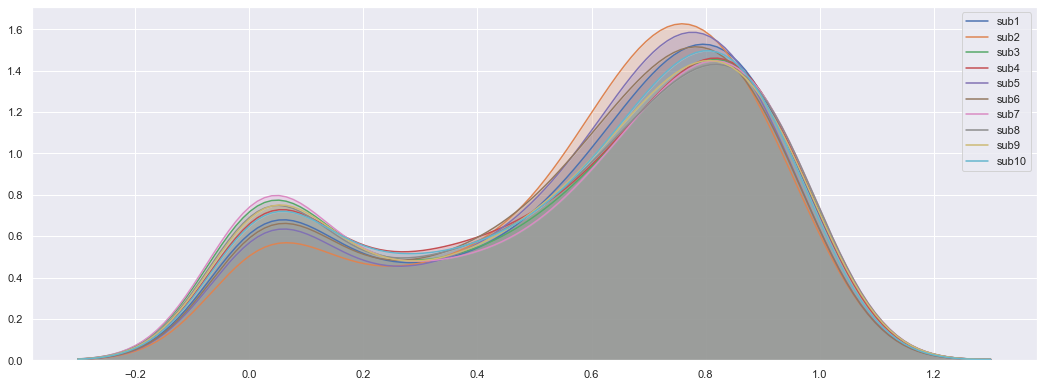

In [24]:
sns.set(rc={'figure.figsize':(18,6.5)})
sns.kdeplot(sub1['is_related'],label="sub1",shade=True,bw=.1)
sns.kdeplot(sub2['is_related'], label="sub2",shade=True,bw=.1)
sns.kdeplot(sub3['is_related'], label="sub3",shade=True,bw=.1)
sns.kdeplot(sub4['is_related'], label="sub4",shade=True,bw=.1)
sns.kdeplot(sub5['is_related'], label="sub5",shade=True,bw=.1)
sns.kdeplot(sub6['is_related'], label="sub6",shade=True,bw=.1)
sns.kdeplot(sub7['is_related'], label="sub7",shade=True,bw=.1)
sns.kdeplot(sub8['is_related'], label="sub8",shade=True,bw=.1)
sns.kdeplot(sub9['is_related'], label="sub9",shade=True,bw=.1)
sns.kdeplot(sub10['is_related'], label="sub10",shade=True,bw=.1)

In [25]:
dd = {1:sub1,2:sub2,3:sub3,4:sub4,5:sub5,6:sub6,7:sub7,8:sub8,9:sub9,10:sub10}
temp['is_related'] = 0.0
for i in [1,3,4,6,7,8,9,10]:
    temp['is_related'] += 0.125*dd[i]['is_related'] 
temp.to_csv('submission3.csv', index=False )

In [3]:

sub1 = pd.read_csv('./input/se_16/vgg_faceF00.csv')
sub2 = pd.read_csv('./input/se_16/vgg_faceF01.csv')
sub3 = pd.read_csv('./input/se_16/vgg_faceF02.csv')
sub4 = pd.read_csv('./input/se_16/vgg_faceF03.csv')
sub5 = pd.read_csv('./input/se_16/vgg_faceF04.csv')
sub6 = pd.read_csv('./input/se_16/vgg_faceF05.csv')
sub7 = pd.read_csv('./input/se_16/vgg_faceF06.csv')
sub8 = pd.read_csv('./input/se_16/vgg_faceF07.csv')
sub9 = pd.read_csv('./input/se_16/vgg_faceF08.csv')
sub10 = pd.read_csv('./input/se_16/vgg_faceF09.csv')

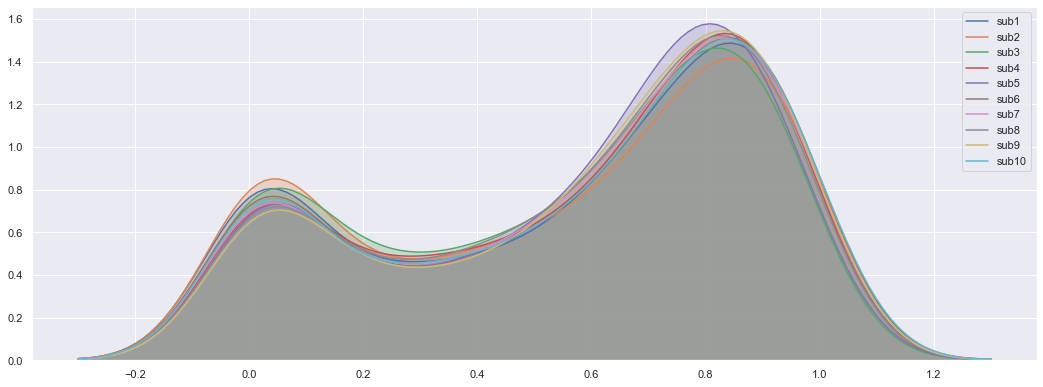

In [4]:
sns.set(rc={'figure.figsize':(18,6.5)})
sns.kdeplot(sub1['is_related'],label="sub1",shade=True,bw=.1)
sns.kdeplot(sub2['is_related'], label="sub2",shade=True,bw=.1)
sns.kdeplot(sub3['is_related'], label="sub3",shade=True,bw=.1)
sns.kdeplot(sub4['is_related'], label="sub4",shade=True,bw=.1)
sns.kdeplot(sub5['is_related'], label="sub5",shade=True,bw=.1)
sns.kdeplot(sub6['is_related'], label="sub6",shade=True,bw=.1)
sns.kdeplot(sub7['is_related'], label="sub7",shade=True,bw=.1)
sns.kdeplot(sub8['is_related'], label="sub8",shade=True,bw=.1)
sns.kdeplot(sub9['is_related'], label="sub9",shade=True,bw=.1)
sns.kdeplot(sub10['is_related'], label="sub10",shade=True,bw=.1)

In [5]:
temp = pd.read_csv('./input/vgg_face (1).csv')
dd = {1:sub1,2:sub2,3:sub3,4:sub4,5:sub5,6:sub6,7:sub7,8:sub8,9:sub9,10:sub10}
temp['is_related'] = 0.0
for i in [1,2,3,4,5,6,7,8,9,10]:
    temp['is_related'] += 0.1*dd[i]['is_related'] 
temp.to_csv('submission4.csv', index=False )

In [5]:
sub11 = pd.read_csv('./input/vgg_faceF00.csv')
sub12 = pd.read_csv('./input/vgg_faceF01.csv')
sub13 = pd.read_csv('./input/vgg_faceF02.csv')
sub14 = pd.read_csv('./input/vgg_faceF03.csv')
sub15 = pd.read_csv('./input/vgg_faceF04.csv')
sub16 = pd.read_csv('./input/vgg_faceF05.csv')
sub17 = pd.read_csv('./input/vgg_faceF06.csv')
sub18 = pd.read_csv('./input/vgg_faceF07.csv')
sub19 = pd.read_csv('./input/vgg_faceF08.csv')
sub20 = pd.read_csv('./input/vgg_faceF09.csv')

In [6]:
temp = pd.read_csv('./input/vgg_face (1).csv')
dd = {1:sub1,2:sub2,3:sub3,4:sub4,5:sub5,6:sub6,7:sub7,8:sub8,9:sub9,10:sub10,
      11:sub11,12:sub12,13:sub13,14:sub14,15:sub15,16:sub16,17:sub17,18:sub18,19:sub19,20:sub20}

temp['is_related'] = 0.0
for i in range(1,21):
    temp['is_related'] += 0.05*dd[i]['is_related'] 
temp.to_csv('submission4.csv', index=False )

In [ ]:
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

In [ ]:
train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [ ]:
def read_img(path):
    img = cv2.imread(path)
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

In [ ]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels

In [ ]:
def baseline_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    # x1_ = Reshape(target_shape=(7*7, 2048))(x1)
    # x2_ = Reshape(target_shape=(7*7, 2048))(x2)
    #
    # x_dot = Dot(axes=[2, 2], normalize=True)([x1_, x2_])
    # x_dot = Flatten()(x_dot)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x = Multiply()([x1, x2])

    x = Concatenate(axis=-1)([x, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([1,2,3],[2,4,3])

In [ ]:
import joblib

In [ ]:
epoch_info = joblib.load('epoch_info1560485905.540373.pkl')

In [ ]:
loss_list = [ [x,epoch_info[x]['loss'],epoch_info[x]['acc']] for x in epoch_info]

In [ ]:
len(loss_list)

In [ ]:
loss_list

In [ ]:
import numpy as np
loss_list = np.array(loss_list)

In [ ]:
plt.plot(loss_list[:, 0], loss_list[:, 1])


In [ ]:
plt.plot(loss_list[:, 0], loss_list[:, 2])

In [ ]:
from torch import nn

In [ ]:
m = nn.Bilinear(20,30,40)
import torch

In [ ]:
import numpy as np

input1 = torch.randn(128, 20)
input2 = torch.randn(128, 30)
output = m(input1, input2)
print(output.size())
arr_output = output.data.cpu().numpy()

weight = m.weight.data.cpu().numpy()
bias = m.bias.data.cpu().numpy()
x1 = input1.data.cpu().numpy()
x2 = input2.data.cpu().numpy()

print(x1.shape, weight.shape, x2.shape, bias.shape)
y = np.zeros((x1.shape[0], weight.shape[0]))

for k in range(weight.shape[0]):
    buff = np.dot(x1, weight[k])
    buff = buff * x2
    buff = np.sum(buff, axis=1)
    y[:, k] = buff

y += bias
dif = y - arr_output
print(np.mean(np.abs(dif.flatten())))


In [ ]:
train_file_path = "Faces_in_the_Wild/train_relationships.csv"

In [ ]:
import pandas as pd
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))

In [ ]:
len(relationships)

In [ ]:
labels = set([])
for x1, x2 in relationships:
    labels.add(x1)
    labels.add(x2)
    

In [ ]:
len(labels
    )

In [ ]:
train_folders_path = "Faces_in_the_Wild/train/"


In [ ]:
from glob import glob

In [ ]:
all_images = glob(train_folders_path + "*/*/*.jpg")

In [ ]:
len(all_images)